# Summit UMC 2025
---

# Machine Learning - Avaliação Cross Validation

---
### Prof. Dr. Fabiano B. Menegidio
---
##### Nome: Anny Gabriely Souza do Nascimento   RGM: 11231103505
##### Nome: Antonio Luiz Lins Neto              RGM: 11231100697
##### Nome: Fábio Yuuki Saruwataru              RGM: 11231102676
##### Nome: Leonardo Valdir Silva               RGM: 11232100617
---

## Breast Cancer Wisconsin (Diagnóstico)

Tipo: Binário (2 classes). Amostras: 569. Atributos: 30.

## 0) Imports e configurações globais

Este bloco é dedicado para importação. Importamos as bibliotecas necessárias para manipulação de dados, visualização e construção dos modelos de machine learning. Essas definições servirão de base para todas as etapas seguintes da análise.

- **Pandas e NumPy**: para manipulação numérica e tabular.  
- **Matplotlib**: para "plotar" artigos visuais (geração de gráficos).  
- **Scikit-learn**: para criação do classificador SVM, métricas de avaliação e métodos de validação cruzada (Cross Validation).

Além disso, definimos algumas **configurações globais**:
- `RANDOM_STATE = 42`: garante **reprodutibilidade**, ou seja, sempre que rodarmos o código os resultados serão os mesmos.  
- `StratifiedKFold`: criamos duas estratégias de validação cruzada estratificada, uma com **10 dobras** (`cv_KFold10`) e outra com **12 dobras** (`cv_KFold12`).  


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

scale = 0
RANDOM_STATE = 42
cv_KFold10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv_KFold12 = StratifiedKFold(n_splits=12, shuffle=True, random_state=RANDOM_STATE)

###**1) Importando e visualizando o dataset**

O dataset **Breast Cancer Wisconsin (Diagnostic)** é carregado a partir de um arquivo CSV usando o `pandas`.  
O arquivo contém **569 amostras** e **30 atributos numéricos**, além da coluna-alvo que indica se o tumor é **benigno** ou **maligno**.  

Em seguida, utilizamos o método `.head()` para exibir as primeiras 5 linhas da tabela.  
Esse passo inicial é importante para confirmar:
- Se o dataset foi carregado corretamente  
- Quais colunas estão presentes
- Se os valores já estão em um formato adequado para análise.  


In [3]:
# Carregar e visualizar Dataset
bc = pd.read_csv('Breast_Cancer_Wisconsin.csv')
bc.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


##**2) Tratamento e processamento do dataset**

###**2.1) Tratamento do dataset**
Nesta etapa removemos colunas que não contribuem para a análise:
- **`id`**: identificador de paciente, não influencia no diagnóstico.  
- **`Unnamed: 32`**: coluna vazia (residuo do CSV).

Essa limpeza garante que o modelo trabalhará apenas com os **30 atributos numéricos relevantes**.



In [4]:
# Eliminando colunas que não são atributos
bc.drop(['Unnamed: 32','id'],axis=1,inplace=True)

### **2.2) Processamento dos dados**
Em seguida, separamos os dados em **atributos (X)** e **variável-alvo (y)**:
- `X`: todos os atributos numéricos.  
- `y`: coluna `diagnosis`, com rótulos *Maligno (M)* ou *Benigno (B)*.

O dataset foi dividido em **80% para treino** e **20% para teste**, utilizando `train_test_split` com `stratify=y`.  
A estratificação garante que a proporção entre classes seja mantida em ambos os conjuntos, evitando que um deles fique desbalanceado.


Como os rótulos estão em formato de string, foi usado `pd.factorize()` para convertê-los em inteiros (0 e 1), facilitando o uso de funções como `np.bincount` e garantindo compatibilidade com algoritmos de aprendizado.

Por fim, é exibido:
- **As dimensões de treino e teste** (quantidade de amostras e atributos).  
- **A distribuição das classes** em cada conjunto, validando que separação representativa foi respeitada.

In [5]:
# Definir variáveis X e y para treino e teste
X = bc.loc[:,bc.columns!="diagnosis"]
y = bc.loc[:,"diagnosis"]

# Divisão treino/teste 80/20 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Converte os rótulos de string para inteiros para usar np.bincount
# O método .factorize() retorna um array de inteiros e um array de rótulos únicos
y_train_num, _ = pd.factorize(y_train)
y_test_num, _ = pd.factorize(y_test)

print("Formas:", "X_train", X_train.shape, "| X_test", X_test.shape)
print("Distribuição de classes (treino):", np.bincount(y_train_num))
print("Distribuição de classes (teste) :", np.bincount(y_test_num))

Formas: X_train (455, 30) | X_test (114, 30)
Distribuição de classes (treino): [170 285]
Distribuição de classes (teste) : [72 42]


##**3) Treino dos dados**

###**3.1) Treino com Kernel linear**
Nesta etapa, treinamos um classificador **SVM (Support Vector Machine)** com **kernel linear**.  

1. **Treinamento:**  
   - O modelo **SVM linear** recebe os dados de treino `X_train` e `y_train`.  
   - Ele busca encontrar o **hiperplano que melhor separa as classes** benigno e maligno.  
   - O critério de "melhor" é maximizar a **margem entre as classes**, ou seja, a distância entre os pontos mais próximos de cada classe e o hiperplano.  
   - Esse hiperplano será usado para classificar novas amostras.

2. **Predição:**  
   - Após o modelo ser treinado, aplicamos `model.predict(X_test)` para **prever os rótulos das amostras de teste**.  
   - Cada ponto de teste é posicionado no espaço das features, e o modelo verifica de que lado do hiperplano ele está, classificando-o como benigno ou maligno.

3. **Avaliação:**  
   - Comparando `y_pred` com os valores reais `y_test`, calculamos a **acurácia**, que indica a proporção de classificações corretas.  
   - Para entender melhor os erros, visualizamos a **matriz de confusão**, que detalha:  
     - Verdadeiros positivos (maligno corretamente detectado)  
     - Verdadeiros negativos (benigno corretamente detectado)  
     - Falsos positivos (benigno classificado como maligno)  
     - Falsos negativos (maligno classificado como benigno)  
   - Esse detalhamento é importante em contextos médicos, pois nem todos os erros têm o mesmo impacto.

Além da acurácia, exibimos:
- As **10 primeiras previsões** comparadas aos rótulos reais.  
- A **matriz de confusão**, que mostra a qualidade da classificação em cada classe.  



A matriz de confusão nos revela:
- Quantos casos malignos foram corretamente detectados (**verdadeiros positivos**).  
- Quantos casos benignos foram corretamente classificados (**verdadeiros negativos**).  
- Onde o modelo cometeu erros (**falsos positivos** e **falsos negativos**).  

Assim, temos uma primeira visão clara do desempenho do SVM linear no diagnóstico do câncer de mama.


[Breast Cancer] Linear — Acurácia: 92.11%
Preditos (10): ['B' 'M' 'B' 'B' 'M' 'B' 'B' 'B' 'B' 'B']
Reais    (10): ['B' 'M' 'B' 'M' 'B' 'B' 'M' 'B' 'B' 'B']


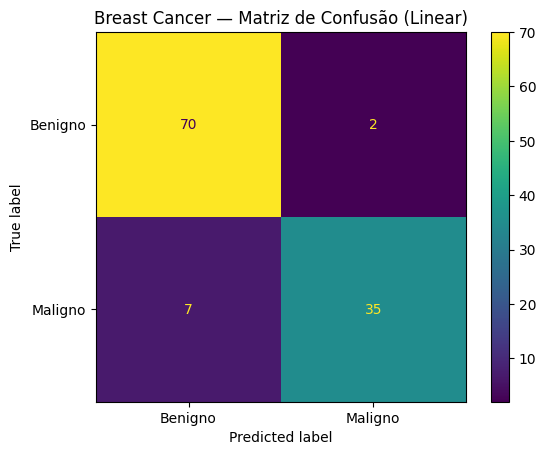

In [6]:
model = SVC(kernel='linear', random_state=RANDOM_STATE)
model.fit(X_train, y_train) #Treina o modelo
y_pred = model.predict(X_test) #Teste baseado no modelo treinado
acc = accuracy_score(y_test, y_pred) #Calculo de acuracidade
labels = ['Benigno', 'Maligno']


# Output
print(f"[Breast Cancer] Linear — Acurácia: {acc*100:.2f}%")
print("Preditos (10):", y_pred[:10])
print("Reais    (10):", y_test.to_numpy()[:10])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Breast Cancer — Matriz de Confusão (Linear)")
plt.show()

###**3.2) Treino com Kernel não-linear RBF**
Treinamos um **SVM com kernel RBF (Radial Basis Function)**.  
Diferente do kernel linear, o RBF consegue capturar **relações não-lineares** entre os atributos, podendo melhorar a classificação quando as classes não são perfeitamente separáveis por um hiperplano.


O fluxo é o mesmo do modelo linear:
1. Treinamento com `X_train` e `y_train`.
2. Predição em `X_test`.
3. Avaliação da acurácia.
4. Visualização da matriz de confusão, mostrando verdadeiros positivos/negativos e erros (falsos positivos/negativos).


[Breast Cancer] RBF — Acurácia: 90.35%
Preditos (10): ['B' 'M' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B']
Reais    (10): ['B' 'M' 'B' 'M' 'B' 'B' 'M' 'B' 'B' 'B']


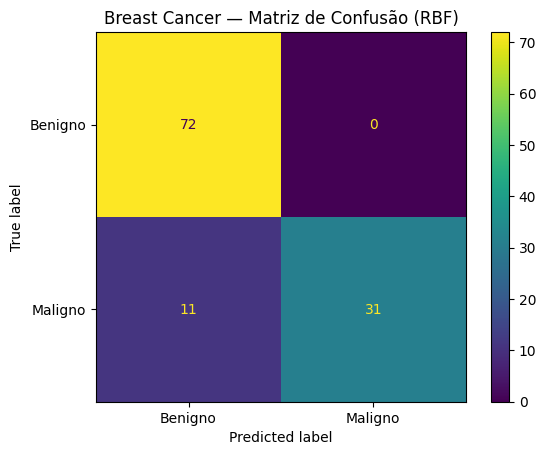

In [7]:
model = SVC(kernel='rbf', random_state=RANDOM_STATE)
model.fit(X_train, y_train) #Treina o modelo
y_pred = model.predict(X_test) #Teste baseado no modelo treinado
acc = accuracy_score(y_test, y_pred) #Calculo de acuracidade
labels = ['Benigno', 'Maligno']


# Output
print(f"[Breast Cancer] RBF — Acurácia: {acc*100:.2f}%")
print("Preditos (10):", y_pred[:10])
print("Reais    (10):", y_test.to_numpy()[:10])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Breast Cancer — Matriz de Confusão (RBF)")
plt.show()

# **StratifiedKFold (K=10)**

## 4) GridSearchCV – Apenas Kernel (SKF-10)

Aqui utilizamos o **GridSearchCV** para encontrar o **melhor kernel** para o SVM, usando **validação cruzada estratificada de 10 dobras (cv_KFold10)**.

1. **Definição do modelo:** `SVC(random_state=RANDOM_STATE)` como modelo base.  
2. **Parâmetros a testar:** `kernel` ∈ ['linear', 'rbf', 'poly', 'sigmoid'].  
3. **Validação cruzada:** cada kernel é avaliado em 10 dobras, preservando a proporção de classes benigno/maligno.  
4. **Escolha do melhor kernel:** o GridSearch seleciona o kernel com **maior média de acurácia** nas 10 dobras.  
5. **Predição e avaliação:** aplicamos o melhor kernel ao conjunto de teste, calculamos a acurácia e geramos a **matriz de confusão** para entender acertos e erros.

[Breast Cancer] Melhor kernel (kernel): linear
[Breast Cancer] Acurácia teste (melhor kernel): 92.98%
TN: 70 FP: 2 FN: 6 TP: 36


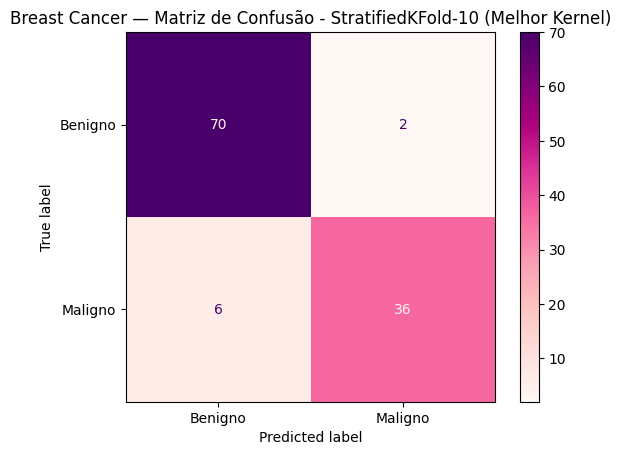

In [13]:
gs = GridSearchCV(
    SVC(random_state=RANDOM_STATE), # Definindo o modelo a utilizar "SVC" SVM-Classificação
    param_grid= {'kernel': ['linear'],
                 'C': [0.01, 0.1, 1, 10, 100]}, # Definindo os parâmetros a serem testados
    cv=cv_KFold10, n_jobs=-1 # n_jobs == paralelismo
    )

gs.fit(X_train, y_train) # Treinando o modelo
best_kernel = gs.best_params_['kernel'] # Definindo o melhor kernel
y_pred = gs.predict(X_test) # Criando a predição
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Output
print("[Breast Cancer] Melhor kernel (kernel):", best_kernel)
print(f"[Breast Cancer] Acurácia teste (melhor kernel): {acc*100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, cmap='RdPu')
plt.title("Breast Cancer — Matriz de Confusão - StratifiedKFold-10 (Melhor Kernel)")
print("TN:", TN, "FP:", FP, "FN:", FN, "TP:", TP)
plt.show()

### 4.1) GridSearchCV – Kernel Linear + Variação de C (SKF-10)

Para complementar a análise, testamos especificamente o **kernel linear** variando o parâmetro **C** em `[0.01, 0.1, 1, 10, 100]` usando **validação cruzada estratificada de 10 dobras (cv_KFold10)**.

**Objetivo:**
- Avaliar como a regularização (C) influencia o desempenho do SVM linear, mantendo o kernel fixo.

Após identificar o melhor C, aplicamos o modelo ao conjunto de teste e geramos a **matriz de confusão** para comparar com o resultado do GridSearch anterior.

[Breast Cancer] Melhor kernel (Grid kernel): linear
[Breast Cancer] Acurácia teste (melhor kernel): 92.11%


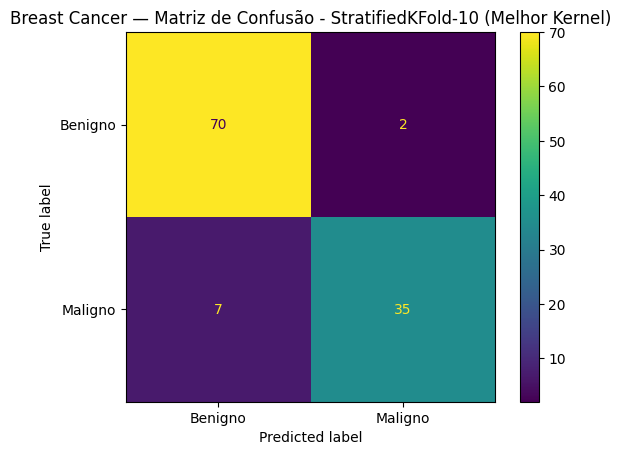

In [ ]:
# Encontrar o melhor kernel para trabalhar com os dados
gs = GridSearchCV(
    SVC(random_state=RANDOM_STATE), # Definindo o modelo a utilizar "SVC" SVM-Classificação
    param_grid={'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}, # Definindo os parâmetros a serem testados
    cv=cv_KFold10, n_jobs=-1 # n_jobs == paralelismo
    )
gs.fit(X_train, y_train) # Treinando o modelo
best_kernel = gs.best_params_['kernel'] # Definindo o melhor kernel
y_pred = gs.predict(X_test) # Criando a predição
acc = accuracy_score(y_test, y_pred)

# Output
print("[Breast Cancer] Melhor kernel (Grid kernel):", best_kernel)
print(f"[Breast Cancer] Acurácia teste (melhor kernel): {acc*100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Breast Cancer — Matriz de Confusão - StratifiedKFold-10 (Melhor Kernel)")
plt.show()

## 5) GridSearchCV – Kernel, C e Gamma (SKF-10)

Nesta etapa está implementado um **GridSearch completo** para explorar o impacto conjunto de **kernel**, **C** e **gamma** no desempenho do SVM.  
Este bloco **é opcional** e pode demandar tempo elevado de execução devido ao grande número de combinações testadas.

**Objetivo:**
- Avaliar simultaneamente diferentes kernels (`linear`, `rbf`, `poly`, `sigmoid`),  
- Vários valores do parâmetro de regularização `C` `[0.01, 0.1, 1, 10, 100]`,  
- E diferentes valores de `gamma` `[scale, 0.01, 0.001]`.

**Processo:**
- Cada combinação é avaliada usando **validação cruzada estratificada de 10 dobras (cv_KFold10)**, preservando a proporção entre classes benigno/maligno.  
- O GridSearch identifica a **melhor combinação de parâmetros** com base na acurácia média das dobras.

**Avaliação:**
- Após encontrar a melhor combinação, aplicamos o modelo ao conjunto de teste.  
- São exibidos:
  - **Acurácia no teste:** proporção de classificações corretas.  
  - **Matriz de confusão:** detalha verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.  

⚠️ **Nota:** devido ao custo computacional elevado, a execução deste bloco pode ser inviável em ambientes limitados (como notebooks em nuvem), mas o código está disponível para execução futura.

In [ ]:
gs_full = GridSearchCV(
    SVC(random_state=RANDOM_STATE),
    param_grid={'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                 'C': [0.01, 0.1, 1, 10, 100],
                 'gamma': [scale, 0.01, 0.001]},
    cv=cv_KFold10, n_jobs=-1 # KFold10
)
gs_full.fit(X_train, y_train)
y_pred = gs_full.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("[Breast Cancer] Melhor combinação (Grid completo):", gs_full.best_params_)
print(f"[Breast Cancer] Acurácia teste (Grid completo): {acc*100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("BREAST CANCER WISCONSIN (Diagnóstico) — Matriz de Confusão (Grid Completo)")
plt.show()

##**6) Varredura de variação de parâmetros**

### **6.1) Variação de C - SKF-10**
Aqui investigamos como o parâmetro **C** afeta o desempenho do SVM linear.  
- **C (regularização):** controla o balanço entre:
  - **margem ampla e tolerância a erros** (C pequeno)  
  - **margem estreita e penalização de erros** (C grande)

Para cada valor de C em `[0.01, 0.1, 1, 10, 100]`:
1. Criamos um **SVM linear** com o valor atual de C.  
2. Avaliamos o modelo usando **validação cruzada estratificada de 10 dobras**, preservando a proporção de classes benigno/maligno em cada dobra.  
3. Calculamos a **média das acurácias** obtidas em cada dobra.

In [8]:
Cs = [0.01, 0.1, 1, 10, 100]
print("[Breast Cancer] CV média (Linear) variando C:")
for C in Cs:
    scores = cross_val_score(SVC(kernel='linear', C=C, random_state=RANDOM_STATE), X, y, cv=cv_KFold10, n_jobs=-1)
    print(f"  C={C}: mean={scores.mean():.4f}")

[Breast Cancer] CV média (Linear) variando C:
  C=0.01: mean=0.9456
  C=0.1: mean=0.9474
  C=1: mean=0.9544
  C=10: mean=0.9526
  C=100: mean=0.9578


### **6.2) Variação de C e Gamma - SKF-10**
Aqui novamente foi feita uma investigação de como a combinação de **C** e **gamma** afeta o desempenho do SVM com kernel RBF.  

- **C (regularização):** controla o equilíbrio entre margem ampla e penalização de erros.  
- **Gamma:** define a influência de cada ponto na fronteira de decisão:
  - Gamma alto → o modelo “segue” mais de perto os pontos de treino (fronteira detalhada/irregular)
  - Gamma baixo → o modelo olha o conjunto de forma mais geral (fronteira mais suave/regular)

Para cada combinação de C e gamma:
1. Criamos um **SVM RBF** com os valores atuais.  
2. Avaliamos o modelo usando **validação cruzada estratificada de 10 dobras**, mantendo a proporção de classes benigno/maligno.  
3. Calculamos a **média das acurácias** obtidas nas 10 dobras.  

[Breast Cancer] CV média (Linear) variando C - SKF10:
  C=0.01: mean=0.9456
  C=0.1: mean=0.9474
  C=1: mean=0.9544
  C=10: mean=0.9526
  C=100: mean=0.9578


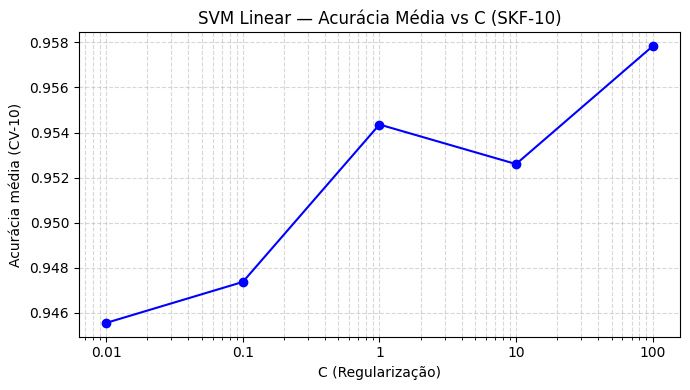

In [13]:
# --- VARREDURA C - SKF10 ---
Cs = [0.01, 0.1, 1, 10, 100]
mean_scores = []

print("[Breast Cancer] CV média (Linear) variando C - SKF10:")
for C in Cs:
    scores = cross_val_score(
        SVC(kernel='linear', C=C, random_state=RANDOM_STATE),
        X, y, cv=cv_KFold10, n_jobs=-1
    )
    mean_score = scores.mean()
    mean_scores.append(mean_score)
    print(f"  C={C}: mean={mean_score:.4f}")

# plot gráfico de linha
plt.figure(figsize=(7,4))
plt.plot(Cs, mean_scores, marker='o', linestyle='-', color='blue')
plt.xscale('log')  # escala log no eixo x (C)
plt.xticks(Cs, Cs) # ticks exatamente nos valores testados
plt.xlabel('C (Regularização)')
plt.ylabel('Acurácia média (CV-10)')
plt.title('SVM Linear — Acurácia Média vs C (SKF-10)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# **7) StratifiedKFold (K=12)**

### **7.2) GridSearchCV – Apenas Kernel – SKF-12**

Nesta etapa repetimos a busca pelo **melhor kernel** usando **validação cruzada estratificada de 12 dobras (SKF-12)**.  
O objetivo é verificar se **aumentar o número de partições** impacta a escolha do kernel ou melhora a estabilidade das métricas obtidas.

- **Objetivo:** avaliar se alterar o número de dobras (de 10 para 12) muda os resultados do GridSearch.  
- **Modelo base:** `SVC(random_state=RANDOM_STATE)`  
- **Parâmetros testados:** `kernel=['linear']` com `C=[0.01, 0.1, 1, 10, 100]`  
- **Validação cruzada:** cada combinação é avaliada em 12 dobras, preservando a proporção de classes benigno/maligno.  

Após identificar a melhor configuração, aplicamos o modelo ao conjunto de teste para medir:  
- **Acurácia:** proporção de classificações corretas no teste.  
- **Matriz de confusão:** detalha verdadeiros positivos/negativos e erros, permitindo comparar o desempenho entre K=10 e K=12.


[Breast Cancer] Melhor kernel (kernel): linear
[Breast Cancer] Acurácia teste (melhor kernel): 92.98%
TN: 70 FP: 2 FN: 6 TP: 36


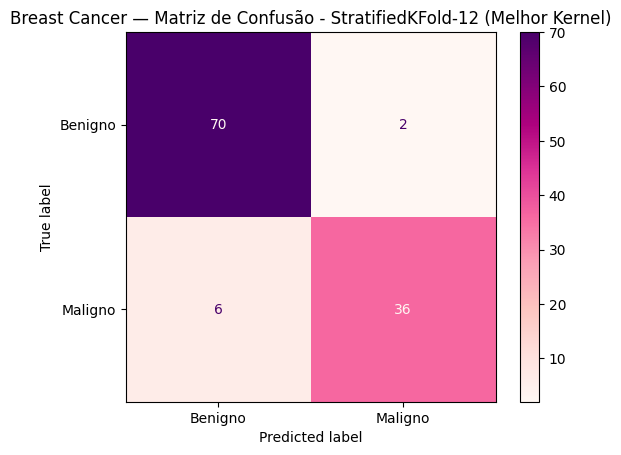

In [14]:
# Encontrar o melhor kernel para trabalhar com os dados
gs = GridSearchCV(
    SVC(random_state=RANDOM_STATE), # Definindo o modelo a utilizar "SVC" SVM-Classificação
    param_grid= {'kernel': ['linear'],
                 'C': [0.01, 0.1, 1, 10, 100]}, # Definindo os parâmetros a serem testados
    cv=cv_KFold12, n_jobs=-1 # n_jobs == paralelismo
    )

gs.fit(X_train, y_train) # Treinando o modelo
best_kernel = gs.best_params_['kernel'] # Definindo o melhor kernel
y_pred = gs.predict(X_test) # Criando a predição
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Output
print("[Breast Cancer] Melhor kernel (kernel):", best_kernel)
print(f"[Breast Cancer] Acurácia teste (melhor kernel): {acc*100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, cmap='RdPu')
plt.title("Breast Cancer — Matriz de Confusão - StratifiedKFold-12 (Melhor Kernel)")
print("TN:", TN, "FP:", FP, "FN:", FN, "TP:", TP)
plt.show()

### **7.3) GridSearchCV – Kernel, C e Gamma – SKF-12**

Aqui realizamos um **GridSearch completo**, agora utilizando **validação cruzada estratificada de 12 dobras (SKF-12)** para identificar a melhor combinação de parâmetros para o SVM.  
Este processo é extremamente custoso computacionalmente e **não foi executado neste notebook**, mas o código permanece aqui para fins de referência metodológica.

- **Parâmetros testados:**  
  - `kernel`: tipo de fronteira de decisão (`linear`, `rbf`, `poly`, `sigmoid`)  
  - `C`: parâmetro de regularização, controla o trade-off entre margem ampla e penalização de erros  
  - `gamma`: influencia a curvatura da fronteira de decisão para kernels não-lineares  

- **Processo:** cada combinação de kernel, C e gamma seria avaliada em 12 dobras, preservando a proporção de classes benigno/maligno em cada partição.  
- **Objetivo:** comparar os resultados obtidos no cenário K=12 com os obtidos em K=10 para entender se há diferenças significativas nas combinações ótimas.  

⚠️ **Nota:** devido ao custo computacional elevado, a execução deste bloco pode ser inviável em ambientes limitados (como notebooks em nuvem), mas o código está disponível para execução futura.


In [ ]:
# Encontrar o melhor kernel para trabalhar com os dados
gs = GridSearchCV(
    SVC(random_state=RANDOM_STATE), # Definindo o modelo a utilizar "SVC" SVM-Classificação
    param_grid={'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}, # Definindo os parâmetros a serem testados
    cv=cv_KFold12, n_jobs=-1 # StratifiedKFold = 12
    )
gs.fit(X_train, y_train) # Treinando o modelo
best_kernel = gs.best_params_['kernel'] # Definindo o melhor kernel
y_pred = gs.predict(X_test) # Criando a predição
acc = accuracy_score(y_test, y_pred)

# Output
print("[Breast Cancer] Melhor kernel (Grid kernel):", best_kernel)
print(f"[Breast Cancer] Acurácia teste (melhor kernel): {acc*100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Breast Cancer — Matriz de Confusão - SKFold-12 (Melhor Kernel)")
plt.show()

## **GridSearchCV - Kernel, C e Gamma - SKF-12**
Nesta etapa, realizamos um **GridSearch completo** usando **Cross Validation de 12 dobras (SKF-12)** para encontrar a melhor combinação de:
- `kernel`: tipo de fronteira de decisão (`linear`, `rbf`, `poly`, `sigmoid`)  
- `C`: parâmetro de regularização, que controla o **equilíbrio entre margem ampla e penalização de erros**  
- `gamma`: influência de cada ponto na fronteira de decisão do kernel

Cada combinação é avaliada em **12 dobras**.


In [ ]:
gs_full = GridSearchCV(
    SVC(random_state=RANDOM_STATE),
    param_grid={'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                 'C': [0.01, 0.1, 1, 10, 100],
                 'gamma': [scale, 0.01, 0.001]},
    cv=cv_KFold12, n_jobs=-1 # KFold12
)
gs_full.fit(X_train, y_train)
y_pred = gs_full.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("[Breast Cancer] Melhor combinação (Grid completo):", gs_full.best_params_)
print(f"[Breast Cancer] Acurácia teste (Grid completo): {acc*100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("BREAST CANCER WISCONSIN (Diagnóstico) — Matriz de Confusão (Grid Completo)")
plt.show()

## **8) Varredura de Variação de Parâmetros – SKF-12**

#### Variação de C – SKF-12  

Nesta etapa investigamos como o parâmetro **C** afeta o desempenho do **SVM linear** usando **validação cruzada estratificada de 12 dobras (SKF-12)**.  

- **C (regularização):** controla o balanço entre:
  - **margem ampla e tolerância a erros** (C pequeno)  
  - **margem estreita e penalização de erros** (C grande)  

**Processo:**  
1. Para cada valor de C em `[0.01, 0.1, 1, 10, 100]`, criamos um **SVM linear** com o valor atual de C.  
2. Avaliamos o modelo usando **validação cruzada estratificada de 12 dobras**, preservando a proporção de classes benigno/maligno em cada partição.  
3. Calculamos e exibimos a **média das acurácias** obtidas nas 12 dobras para cada valor de C.  

Essa análise permite observar **como diferentes níveis de regularização impactam o desempenho do modelo** no cenário K=12, auxiliando na escolha de valores de C mais adequados.


[Breast Cancer] CV média (Linear) variando C - SKF12:
  C=0.01: mean=0.9492
  C=0.1: mean=0.9509
  C=1: mean=0.9579
  C=10: mean=0.9526
  C=100: mean=0.9563


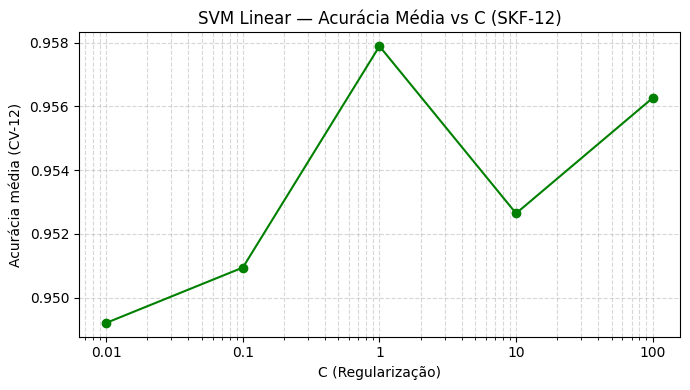

In [14]:
# --- VARREDURA C - SKF12 ---
Cs = [0.01, 0.1, 1, 10, 100]
mean_scores_12 = []

print("[Breast Cancer] CV média (Linear) variando C - SKF12:")
for C in Cs:
    scores = cross_val_score(
        SVC(kernel='linear', C=C, random_state=RANDOM_STATE),
        X, y, cv=cv_KFold12, n_jobs=-1
    )
    mean_score = scores.mean()
    mean_scores_12.append(mean_score)
    print(f"  C={C}: mean={mean_score:.4f}")

# plot gráfico de linha
plt.figure(figsize=(7,4))
plt.plot(Cs, mean_scores_12, marker='o', linestyle='-', color='green')
plt.xscale('log')  # escala log no eixo x (C)
plt.xticks(Cs, Cs)
plt.xlabel('C (Regularização)')
plt.ylabel('Acurácia média (CV-12)')
plt.title('SVM Linear — Acurácia Média vs C (SKF-12)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
